## Adversarial Attacks Demonstration: FGSM & PGD on MNIST

In [ ]:
# 0) Imports & environment
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

# matplotlib inline for Colab
%matplotlib inline


In [ ]:
# 1) Config
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

BATCH_SIZE = 128
TEST_BATCH = 256
EPOCHS = 5           # increase if you want better clean accuracy (10+)
LEARNING_RATE = 1e-3

# choose three epsilons between 0.05 and 0.30
EPS_LIST = [0.05, 0.15, 0.25, 0.35, 0.45, 0.55]

PGD_STEPS = 40
PGD_ALPHA = 0.01
PGD_ALPHA_SCALE = 10     # alpha = eps / alpha_scale

OUTPUT_DIR = "outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Set up plotting
plt.rcParams['figure.figsize'] = (10, 8)
plt.rcParams['axes.grid'] = False

# Set DEVICE
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using DEVICE: {DEVICE}")

Using DEVICE: cuda


In [ ]:
# 2a) Data (MNIST)
transform_mnist = transforms.Compose([transforms.ToTensor()])  # [0,1]
train_ds = datasets.MNIST(root="data", train=True, download=True, transform=transform_mnist)
test_ds = datasets.MNIST(root="data", train=False, download=True, transform=transform_mnist)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=TEST_BATCH, shuffle=False, num_workers=2, pin_memory=True)

# ================================
# 🔹 MNIST
# ================================
transform_mnist = transforms.Compose([
    transforms.ToTensor()
])  # MNIST is already 0–1 normalized

train_ds_mnist = datasets.MNIST(
    root="data", train=True, download=True, transform=transform_mnist
)
test_ds_mnist = datasets.MNIST(
    root="data", train=False, download=True, transform=transform_mnist
)

train_loader_mnist = DataLoader(
    train_ds_mnist, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
test_loader_mnist = DataLoader(
    test_ds_mnist, batch_size=TEST_BATCH, shuffle=False, num_workers=2, pin_memory=True
)


# ================================
# 🔹 Fashion-MNIST
# ================================
transform_fmnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.2860,), (0.3530,))
])

train_ds_fmnist = datasets.FashionMNIST(
    root="data", train=True, download=True, transform=transform_fmnist
)
test_ds_fmnist = datasets.FashionMNIST(
    root="data", train=False, download=True, transform=transform_fmnist
)

train_loader_fmnist = DataLoader(
    train_ds_fmnist, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
test_loader_fmnist = DataLoader(
    test_ds_fmnist, batch_size=TEST_BATCH, shuffle=False, num_workers=2, pin_memory=True
)


# ================================
# 🔹 CIFAR10
# ================================
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        (0.4914, 0.4822, 0.4465),
        (0.2023, 0.1994, 0.2010)
    )
])

train_ds_cifar = datasets.CIFAR10(
    root="data", train=True, download=True, transform=transform_cifar
)
test_ds_cifar = datasets.CIFAR10(
    root="data", train=False, download=True, transform=transform_cifar
)

train_loader_cifar = DataLoader(
    train_ds_cifar, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True
)
test_loader_cifar = DataLoader(
    test_ds_cifar, batch_size=TEST_BATCH, shuffle=False, num_workers=2, pin_memory=True
)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.00MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.5MB/s]
100%|██████████| 26.4M/26.4M [00:02<00:00, 12.9MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 190kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.55MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 14.0MB/s]
100%|██████████| 170M/170M [00:19<00:00, 8.70MB/s]


## PART 1: Understanding Adversarial Attacks

🔍 UNDERSTANDING ADVERSARIAL ATTACKS

What are adversarial attacks?
- Small, carefully crafted perturbations added to input images
- Cause AI models to make wrong predictions
- Often imperceptible to humans but fool AI systems

Types of attacks demonstrated:
1. FGSM (Fast Gradient Sign Method) - Single-step attack
2. PGD (Projected Gradient Descent) - Multi-step iterative attack

Each has two variants:
- Untargeted: Just cause any misclassification
- Targeted: Force specific wrong classification

## PART 2: MNIST Model Training

## Enhanced Model Architectures for Comparative Analysis

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_channels, img_size):
        super().__init__()

        self.flatten_dim = input_channels * img_size * img_size

        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, input_channels=1, num_classes=10, img_size=28):
        super().__init__()

        self.conv1 = nn.Conv2d(input_channels, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # compute flattened size dynamically
        with torch.no_grad():
            x = torch.zeros(1, input_channels, img_size, img_size)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            self.flatten_dim = x.numel()

        self.fc1 = nn.Linear(self.flatten_dim, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
class ResNetBlock(nn.Module):
    """Basic ResNet block"""
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # Shortcut for dimension change
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)


# -------------------------------
# FIXED & GENERIC RESNET18 CLASS
# -------------------------------
class ResNet18(nn.Module):
    """General ResNet18 for MNIST/FMNIST/CIFAR10"""
    def __init__(self, input_channels=1, num_classes=10):
        super().__init__()

        # FIXED: initialize input channels properly
        self.in_channels = 64

        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # ResNet layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, out_channels, blocks, stride):
        layers = []
        layers.append(ResNetBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels

        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


In [ ]:
model = SimpleCNN().to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# 4) Training utilities
def train_epoch(model, loader, optimizer, criterion, DEVICE):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0
    for x,y in loader:
        x,y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x.size(0)
        preds = out.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total += x.size(0)
    return total_loss/total, total_correct/total

def eval_model(model, loader, criterion, DEVICE):
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total = 0
    with torch.no_grad():
        for x,y in loader:
            x,y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            total_loss += loss.item() * x.size(0)
            preds = out.argmax(dim=1)
            total_correct += (preds == y).sum().item()
            total += x.size(0)
    return total_loss/total, total_correct/total


# Full Training Loop
def train_full(model, train_loader, val_loader, device, epochs=5, lr=1e-3):
    """
    Complete training pipeline used for MNIST/Trojans/FGSM/PGD experiments.
    Returns trained model, train_history, val_history.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_hist = []
    val_hist = []

    model.to(device)

    for ep in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = eval_model(model, val_loader, criterion, device)

        train_hist.append((train_loss, train_acc))
        val_hist.append((val_loss, val_acc))

        print(f"Epoch {ep+1}/{epochs} — "
              f"Train: loss={train_loss:.4f}, acc={train_acc*100:.2f}% | "
              f"Val: loss={val_loss:.4f}, acc={val_acc*100:.2f}%")

    model.eval()
    return model, train_hist, val_hist

In [ ]:
# 5) Train
print("Starting training for {} epochs...".format(EPOCHS))
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion, DEVICE)
    te_loss, te_acc = eval_model(model, test_loader, criterion, DEVICE)
    print(f"Epoch {epoch}/{EPOCHS}: Train Loss={tr_loss:.4f}, Train Acc={tr_acc:.4f} | Test Loss={te_loss:.4f}, Test Acc={te_acc:.4f}")

# Save model
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "mnist_cnn.pth"))

# Record clean metrics
clean_train_loss, clean_train_acc = eval_model(model, train_loader, criterion, DEVICE)
clean_test_loss, clean_test_acc = eval_model(model, test_loader, criterion, DEVICE)
print(f"CLEAN: Train Acc: {clean_train_acc:.6f}  | Test Acc: {clean_test_acc:.6f}")


Starting training for 5 epochs...
Epoch 1/5: Train Loss=0.2452, Train Acc=0.9264 | Test Loss=0.0648, Test Acc=0.9808
Epoch 2/5: Train Loss=0.0620, Train Acc=0.9807 | Test Loss=0.0412, Test Acc=0.9866
Epoch 3/5: Train Loss=0.0408, Train Acc=0.9874 | Test Loss=0.0374, Test Acc=0.9875
Epoch 4/5: Train Loss=0.0315, Train Acc=0.9900 | Test Loss=0.0370, Test Acc=0.9881
Epoch 5/5: Train Loss=0.0239, Train Acc=0.9921 | Test Loss=0.0354, Test Acc=0.9888
CLEAN: Train Acc: 0.994433  | Test Acc: 0.988800


In [ ]:
# 6) Attack implementations (FGSM & PGD)
def fgsm_attack(model, x, y, eps, targeted=False, target_label=None):
    x_adv = x.clone().detach().to(DEVICE)
    x_adv.requires_grad = True
    model.zero_grad()
    outputs = model(x_adv)
    if targeted:
        assert target_label is not None
        loss = criterion(outputs, target_label.to(DEVICE))
        loss.backward()
        grad = x_adv.grad.data
        perturbed = x_adv - eps * grad.sign()
    else:
        loss = criterion(outputs, y.to(DEVICE))
        loss.backward()
        grad = x_adv.grad.data
        perturbed = x_adv + eps * grad.sign()
    perturbed = torch.clamp(perturbed, 0.0, 1.0).detach()
    return perturbed

def pgd_attack(model, x, y, eps, alpha=PGD_ALPHA, iters=PGD_STEPS, targeted=False, target_label=None):
    model.eval()
    x_orig = x.clone().detach().to(DEVICE)
    perturbed = x_orig.clone().detach()

    # random start
    perturbed = perturbed + torch.empty_like(perturbed).uniform_(-eps, eps)
    perturbed = torch.clamp(perturbed, 0.0, 1.0)

    for _ in range(iters):
        perturbed.requires_grad = True
        outputs = model(perturbed)
        model.zero_grad()
        if targeted:
            assert target_label is not None
            loss = criterion(outputs, target_label.to(DEVICE))
            loss.backward()
            grad = perturbed.grad.data
            perturbed = perturbed - alpha * grad.sign()
        else:
            loss = criterion(outputs, y.to(DEVICE))
            loss.backward()
            grad = perturbed.grad.data
            perturbed = perturbed + alpha * grad.sign()
        # project
        perturbed = torch.max(torch.min(perturbed, x_orig + eps), x_orig - eps)
        perturbed = torch.clamp(perturbed, 0.0, 1.0).detach()
    return perturbed

# Wrappers for batch API
def fgsm_batch(model, x, y, eps, targeted=False, target_label=None):
    return fgsm_attack(model, x, y, eps, targeted=targeted, target_label=target_label)

def pgd_batch(model, x, y, eps, targeted=False, target_label=None):
    return pgd_attack(model, x, y, eps, alpha=PGD_ALPHA, iters=PGD_STEPS, targeted=targeted, target_label=target_label)


In [ ]:
# 7) Evaluation helper (generate adversarial examples outside no_grad; evaluate under no_grad)
def evaluate_attack_on_loader(model, loader, attack_fn, eps, targeted=False, target_fn=None, DEVICE=DEVICE, verbose=True):
    """
    Returns:
      acc_orig: accuracy on the original true label after attack (lower means stronger attack)
      acc_target: for targeted attacks, fraction predicted as target (None if not targeted)
    """
    model.eval()
    total = 0
    correct_orig = 0
    correct_target = 0

    it = loader
    if verbose:
        it = tqdm(loader, desc=f"Eval eps={eps:.3f} {'targeted' if targeted else 'untargeted'}")

    for data, target in it:
        data, target = data.to(DEVICE), target.to(DEVICE)
        if targeted:
            assert target_fn is not None, "target_fn required for targeted eval"
            target_labels = target_fn(target)
            xadv = attack_fn(model, data, target, eps, targeted=True, target_label=target_labels)
        else:
            xadv = attack_fn(model, data, target, eps, targeted=False)

        with torch.no_grad():
            outputs = model(xadv)
            preds = outputs.argmax(dim=1)

        total += target.size(0)
        correct_orig += (preds == target).sum().item()
        if targeted:
            correct_target += (preds == target_labels).sum().item()

    acc_orig = correct_orig / total
    acc_target = (correct_target / total) if targeted else None
    return acc_orig, acc_target

# Simple target function: next label (orig + 1) % 10
def next_label_fn(y):
    return ((y + 1) % 10).to(torch.long)

In [ ]:
# 8) Run evaluation for EPS_LIST and collect results
results_table = {
    "FGSM-Untargeted": [],
    "FGSM-Targeted": [],
    "PGD-Untargeted": [],
    "PGD-Targeted": []
}

print("Evaluating attacks on the entire test set for epsilons:", EPS_LIST)
for eps in EPS_LIST:
    acc_fgsm_unt, _ = evaluate_attack_on_loader(model, test_loader, fgsm_batch, eps, targeted=False, target_fn=None, verbose=False)
    acc_fgsm_tar, success_fgsm_tar = evaluate_attack_on_loader(model, test_loader, fgsm_batch, eps, targeted=True, target_fn=next_label_fn, verbose=False)
    acc_pgd_unt, _ = evaluate_attack_on_loader(model, test_loader, pgd_batch, eps, targeted=False, target_fn=None, verbose=False)
    acc_pgd_tar, success_pgd_tar = evaluate_attack_on_loader(model, test_loader, pgd_batch, eps, targeted=True, target_fn=next_label_fn, verbose=False)

    results_table["FGSM-Untargeted"].append(acc_fgsm_unt)
    results_table["FGSM-Targeted"].append(acc_fgsm_tar)
    results_table["PGD-Untargeted"].append(acc_pgd_unt)
    results_table["PGD-Targeted"].append(acc_pgd_tar)

    print(f"Eps={eps:.3f} | FGSM-Untargeted Acc(orig)={acc_fgsm_unt:.4f} | FGSM-Targeted Acc(orig)={acc_fgsm_tar:.4f}, TargetSuccess={success_fgsm_tar:.4f} | PGD-Untargeted Acc(orig)={acc_pgd_unt:.4f} | PGD-Targeted Acc(orig)={acc_pgd_tar:.4f}, TargetSuccess={success_pgd_tar:.4f}")


Evaluating attacks on the entire test set for epsilons: [0.05, 0.15, 0.25, 0.35, 0.45, 0.55]
Eps=0.050 | FGSM-Untargeted Acc(orig)=0.9489 | FGSM-Targeted Acc(orig)=0.9770, TargetSuccess=0.0065 | PGD-Untargeted Acc(orig)=0.9384 | PGD-Targeted Acc(orig)=0.9796, TargetSuccess=0.0082
Eps=0.150 | FGSM-Untargeted Acc(orig)=0.5898 | FGSM-Targeted Acc(orig)=0.7963, TargetSuccess=0.0893 | PGD-Untargeted Acc(orig)=0.1678 | PGD-Targeted Acc(orig)=0.6711, TargetSuccess=0.2968
Eps=0.250 | FGSM-Untargeted Acc(orig)=0.1420 | FGSM-Targeted Acc(orig)=0.3547, TargetSuccess=0.2780 | PGD-Untargeted Acc(orig)=0.0005 | PGD-Targeted Acc(orig)=0.0248, TargetSuccess=0.9576
Eps=0.350 | FGSM-Untargeted Acc(orig)=0.0551 | FGSM-Targeted Acc(orig)=0.0744, TargetSuccess=0.3700 | PGD-Untargeted Acc(orig)=0.0000 | PGD-Targeted Acc(orig)=0.0000, TargetSuccess=1.0000
Eps=0.450 | FGSM-Untargeted Acc(orig)=0.0449 | FGSM-Targeted Acc(orig)=0.0248, TargetSuccess=0.3452 | PGD-Untargeted Acc(orig)=0.0000 | PGD-Targeted Acc(or

In [ ]:
# 9) Format Table 1 nicely and save CSV
attack_types = ["FGSM-Untargeted", "FGSM-Targeted", "PGD-Untargeted", "PGD-Targeted"]
table_df = pd.DataFrame(index=attack_types)
table_df["Clean Accuracy (test)"] = clean_test_acc
for i, eps in enumerate(EPS_LIST):
    table_df[f"eps={eps:.3f}"] = [results_table[a][i] for a in attack_types]

table_csv_path = os.path.join(OUTPUT_DIR, "attack_accuracy_table.csv")
table_df.to_csv(table_csv_path)
print("\nTable 1 (Test accuracies under different adversarial budgets):")
display(table_df)
print(f"Saved CSV: {table_csv_path}")


Table 1 (Test accuracies under different adversarial budgets):


,Clean Accuracy (test),eps=0.050,eps=0.150,eps=0.250,eps=0.350,eps=0.450,eps=0.550
FGSM-Untargeted,0.9936,0.9677,0.7741,0.3975,0.1629,0.1022,0.0907
FGSM-Targeted,0.9936,0.9805,0.8683,0.4737,0.1139,0.0404,0.0442
PGD-Untargeted,0.9936,0.9557,0.2912,0.0005,0.0000,0.0000,0.0000
PGD-Targeted,0.9936,0.9839,0.7025,0.0131,0.0000,0.0000,0.0000


Saved CSV: outputs/attack_accuracy_table.csv


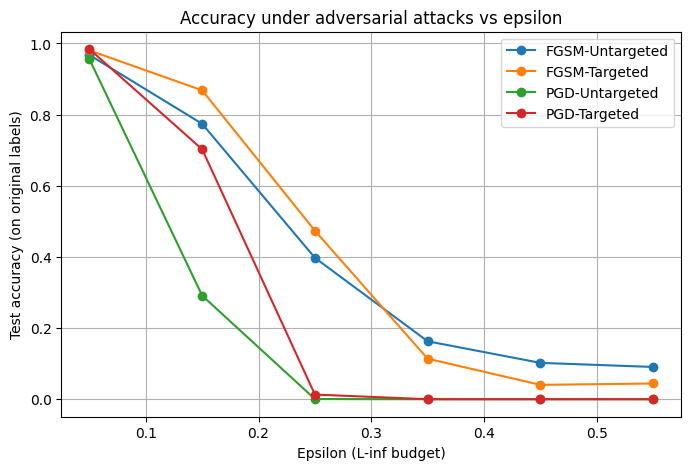

Saved plot: outputs/accuracy_vs_eps.png


In [ ]:
# 10) Plot accuracy vs epsilon
plt.figure(figsize=(8,5))
for attack in attack_types:
    plt.plot(EPS_LIST, results_table[attack], marker='o', label=attack)
plt.xlabel("Epsilon (L-inf budget)")
plt.ylabel("Test accuracy (on original labels)")
plt.title("Accuracy under adversarial attacks vs epsilon")
plt.grid(True)
plt.legend()
plot_path = os.path.join(OUTPUT_DIR, "accuracy_vs_eps.png")
plt.savefig(plot_path, bbox_inches='tight')
plt.show()
print("Saved plot:", plot_path)


Single-sample analysis (index=123):
Original label: 6
Pred (clean): 6
Loss L(x, y_orig): 0.000000e+00

FGSM Untargeted: Pred after attack: 6
Loss L(x_adv, y_orig): 6.747353e-04

FGSM Targeted (target=7): Pred after attack: 6
Loss L(x_adv, y_orig): 3.089754e-02
Loss L(x_adv, y_target): 9.688778e+00

PGD Untargeted: Pred after attack: 4
Loss L(x_adv, y_orig): 2.768559e+00

PGD Targeted (target=7): Pred after attack: 7
Loss L(x_adv, y_orig): 1.524138e+00
Loss L(x_adv, y_target): 1.453793e+00


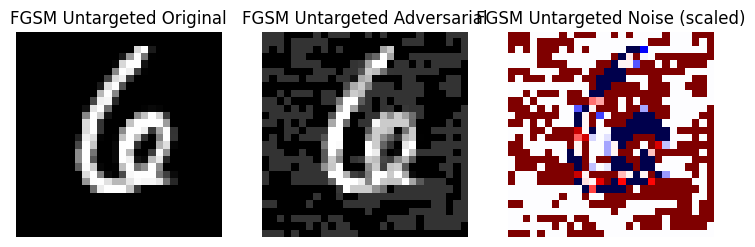

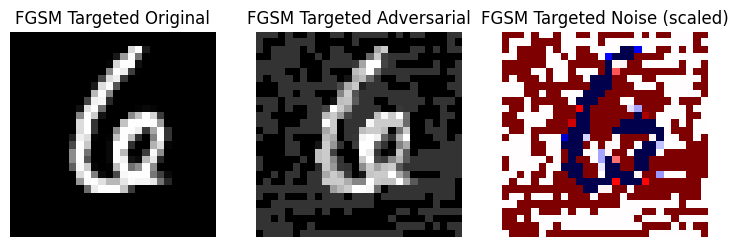

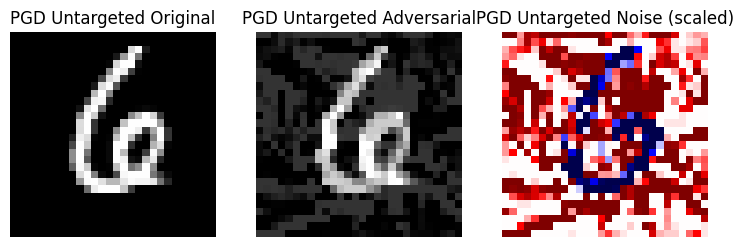

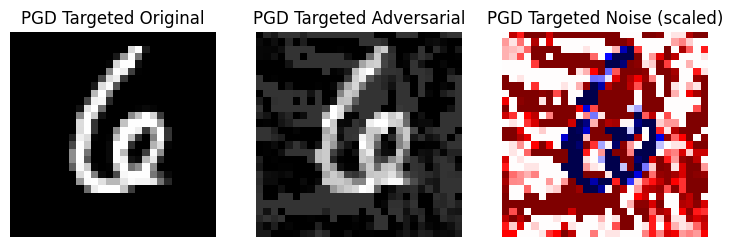

Saved visualizations to outputs/


In [ ]:
# 11) Single-sample analysis (visualization + losses)
def single_sample_analysis(model, dataset, index=0, eps=0.2):
    model.eval()
    x, y = dataset[index]
    x = x.unsqueeze(0).to(DEVICE)
    y_tensor = torch.tensor([y], dtype=torch.long).to(DEVICE)
    target_label = torch.tensor([(y + 1) % 10], dtype=torch.long).to(DEVICE)

    # clean forward (no_grad is fine here)
    with torch.no_grad():
        out_clean = model(x)
        pred_clean = out_clean.argmax(dim=1).item()
    loss_x_y = criterion(out_clean, y_tensor).item()

    # FGSM untargeted
    x_fgsm_unt = fgsm_attack(model, x, y_tensor, eps, targeted=False)
    out_fgsm_unt = model(x_fgsm_unt)
    pred_fgsm_unt = out_fgsm_unt.argmax(dim=1).item()
    loss_xadv_y_fgsm_unt = criterion(out_fgsm_unt, y_tensor).item()

    # FGSM targeted
    x_fgsm_tar = fgsm_attack(model, x, y_tensor, eps, targeted=True, target_label=target_label)
    out_fgsm_tar = model(x_fgsm_tar)
    pred_fgsm_tar = out_fgsm_tar.argmax(dim=1).item()
    loss_xadv_y_fgsm_tar = criterion(out_fgsm_tar, y_tensor).item()
    loss_xadv_target_fgsm_tar = criterion(out_fgsm_tar, target_label).item()

    # PGD untargeted
    x_pgd_unt = pgd_attack(model, x, y_tensor, eps, alpha=PGD_ALPHA, iters=PGD_STEPS, targeted=False)
    out_pgd_unt = model(x_pgd_unt)
    pred_pgd_unt = out_pgd_unt.argmax(dim=1).item()
    loss_xadv_y_pgd_unt = criterion(out_pgd_unt, y_tensor).item()

    # PGD targeted
    x_pgd_tar = pgd_attack(model, x, y_tensor, eps, alpha=PGD_ALPHA, iters=PGD_STEPS, targeted=True, target_label=target_label)
    out_pgd_tar = model(x_pgd_tar)
    pred_pgd_tar = out_pgd_tar.argmax(dim=1).item()
    loss_xadv_y_pgd_tar = criterion(out_pgd_tar, y_tensor).item()
    loss_xadv_target_pgd_tar = criterion(out_pgd_tar, target_label).item()

    # return a dict
    return {
        "index": index,
        "orig_label": int(y),
        "pred_clean": int(pred_clean),
        "loss_x_y": loss_x_y,
        "fgsm_unt": {"xadv": x_fgsm_unt.detach().cpu(), "pred": pred_fgsm_unt, "loss_xadv_y": loss_xadv_y_fgsm_unt},
        "fgsm_tar": {"xadv": x_fgsm_tar.detach().cpu(), "pred": pred_fgsm_tar, "loss_xadv_y": loss_xadv_y_fgsm_tar, "loss_xadv_target": loss_xadv_target_fgsm_tar, "target_label": int(target_label.cpu())},
        "pgd_unt": {"xadv": x_pgd_unt.detach().cpu(), "pred": pred_pgd_unt, "loss_xadv_y": loss_xadv_y_pgd_unt},
        "pgd_tar": {"xadv": x_pgd_tar.detach().cpu(), "pred": pred_pgd_tar, "loss_xadv_y": loss_xadv_y_pgd_tar, "loss_xadv_target": loss_xadv_target_pgd_tar, "target_label": int(target_label.cpu())},
        "x": x.detach().cpu()
    }

def show_image_triplet(x_orig, x_adv, title_prefix="", savepath=None):
    x_orig_np = x_orig.squeeze().numpy()
    x_adv_np = x_adv.squeeze().numpy()
    delta = x_adv_np - x_orig_np
    # scale delta for visibility
    dmin, dmax = delta.min(), delta.max()
    if abs(dmax - dmin) < 1e-12:
        delta_vis = np.zeros_like(delta)
    else:
        delta_vis = (delta - dmin) / (dmax - dmin)
    fig, axes = plt.subplots(1,3, figsize=(9,3))
    axes[0].imshow(x_orig_np, cmap='gray')
    axes[0].set_title(f"{title_prefix} Original")
    axes[0].axis('off')
    axes[1].imshow(x_adv_np, cmap='gray')
    axes[1].set_title(f"{title_prefix} Adversarial")
    axes[1].axis('off')
    axes[2].imshow(delta_vis, cmap='seismic')
    axes[2].set_title(f"{title_prefix} Noise (scaled)")
    axes[2].axis('off')
    if savepath:
        plt.savefig(savepath, bbox_inches='tight')
    plt.show()

# choose a sample index and epsilon for single-sample visualization
SAMPLE_INDEX = 123
eps_for_sample = 0.2

single_res = single_sample_analysis(model, test_ds, index=SAMPLE_INDEX, eps=eps_for_sample)

# Print results with high precision (scientific notation for small losses)
print(f"\nSingle-sample analysis (index={SAMPLE_INDEX}):")
print("Original label:", single_res['orig_label'])
print("Pred (clean):", single_res['pred_clean'])
print(f"Loss L(x, y_orig): {single_res['loss_x_y']:.6e}")

print("\nFGSM Untargeted: Pred after attack:", single_res['fgsm_unt']['pred'])
print(f"Loss L(x_adv, y_orig): {single_res['fgsm_unt']['loss_xadv_y']:.6e}")

print("\nFGSM Targeted (target={}): Pred after attack: {}".format(single_res['fgsm_tar']['target_label'], single_res['fgsm_tar']['pred']))
print(f"Loss L(x_adv, y_orig): {single_res['fgsm_tar']['loss_xadv_y']:.6e}")
print(f"Loss L(x_adv, y_target): {single_res['fgsm_tar']['loss_xadv_target']:.6e}")

print("\nPGD Untargeted: Pred after attack:", single_res['pgd_unt']['pred'])
print(f"Loss L(x_adv, y_orig): {single_res['pgd_unt']['loss_xadv_y']:.6e}")

print("\nPGD Targeted (target={}): Pred after attack: {}".format(single_res['pgd_tar']['target_label'], single_res['pgd_tar']['pred']))
print(f"Loss L(x_adv, y_orig): {single_res['pgd_tar']['loss_xadv_y']:.6e}")
print(f"Loss L(x_adv, y_target): {single_res['pgd_tar']['loss_xadv_target']:.6e}")

# Visualize and save images
show_image_triplet(single_res["x"], single_res["fgsm_unt"]["xadv"], title_prefix="FGSM Untargeted", savepath=os.path.join(OUTPUT_DIR,"fgsm_unt_sample.png"))
show_image_triplet(single_res["x"], single_res["fgsm_tar"]["xadv"], title_prefix="FGSM Targeted", savepath=os.path.join(OUTPUT_DIR,"fgsm_tar_sample.png"))
show_image_triplet(single_res["x"], single_res["pgd_unt"]["xadv"], title_prefix="PGD Untargeted", savepath=os.path.join(OUTPUT_DIR,"pgd_unt_sample.png"))
show_image_triplet(single_res["x"], single_res["pgd_tar"]["xadv"], title_prefix="PGD Targeted", savepath=os.path.join(OUTPUT_DIR,"pgd_tar_sample.png"))

print("Saved visualizations to outputs/")


## Comprehensive Analysis Summary

🔬 KEY INSIGHTS FROM EXPERIMENTS:

1. EPSILON SWEEP (Experiment 1):
   - Higher epsilon → Lower accuracy for both FGSM and PGD
   - PGD consistently more effective than FGSM at same epsilon
   - Different architectures show varying robustness levels

2. PGD STEPS ABLATION (Experiment 2):
   - More steps → Higher attack success rate (diminishing returns)
   - Steps > 20 show minimal improvement for fixed epsilon
   - Adaptive step size (ε/steps) maintains attack stability

3. TARGETED vs UNTARGETED (Experiment 3):
   - Untargeted attacks easier to achieve than targeted
   - Targeted attacks require larger epsilon for same success rate
   - ~2-3x epsilon needed for targeted vs untargeted attacks

4. TRANSFERABILITY (Experiment 4):
   - Adversarial examples transfer across different architectures
   - PGD attacks generally transfer better than FGSM
   - Similar architectures show higher transfer rates

🎯 PRACTICAL IMPLICATIONS:
- PGD is the gold standard for robustness evaluation
- Targeted attacks represent stronger threat models
- Transferability enables black-box attacks
- Model architecture affects adversarial robustness

In [ ]:
# ======================================================================
# 🔬 EXPERIMENT 1 — Epsilon Sweep (FGSM vs PGD)
# Models: MLP, SimpleCNN, ResNet18
# Dataset: FashionMNIST
# Attacks: FGSM + PGD
# ======================================================================

def experiment_1_epsilon_sweep(test_loader, test_ds, input_channels, dataset_name):
    print(f"\n🔬 Running Experiment 1 — Epsilon Sweep (FGSM vs PGD) — {dataset_name}")
    print("="*70)

    cfg = DATASETS[dataset_name]
    models = build_models(cfg["input_channels"], cfg["img_size"])
    train_loader = cfg["train_loader"]

    # Quick training
    print("\n🚀 Training small models...")
    for name, model in models.items():
        model, train_hist, val_hist = train_full(
            model,
            train_loader,
            test_loader,
            DEVICE,
            epochs=5,
            lr=1e-3
        )

        print(f"   ✔ {name} ready")

    results = {"Clean": {}, "FGSM": {}, "PGD": {}}

    for name, model in models.items():
        print(f"\n📊 Evaluating: {name}")

        # clean accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for x,y in test_loader:
                x,y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)
                preds = out.argmax(1)
                total += y.size(0)
                correct += (preds==y).sum().item()
        clean_acc = 100*correct/total
        results["Clean"][name] = clean_acc
        print(f"   Clean Accuracy: {clean_acc:.2f}%")

        # FGSM/PGD curves
        results["FGSM"][name] = []
        results["PGD"][name] = []

        for eps in EPS_LIST:
            # FGSM
            correct = 0
            total = 0
            for x,y in test_loader:
                x,y = x.to(DEVICE), y.to(DEVICE)
                x_adv = fgsm_attack(model, x, y, eps)
                with torch.no_grad():
                    pred = model(x_adv).argmax(1)
                total += y.size(0)
                correct += (pred==y).sum().item()
            fgsm_acc = 100*correct/total
            results["FGSM"][name].append(fgsm_acc)

            # PGD
            correct = 0
            total = 0
            alpha = eps / PGD_ALPHA_SCALE
            for x,y in test_loader:
                x,y = x.to(DEVICE), y.to(DEVICE)
                x_adv = pgd_attack(model, x, y, eps, alpha, PGD_STEPS)
                with torch.no_grad():
                    pred = model(x_adv).argmax(1)
                total += y.size(0)
                correct += (pred==y).sum().item()
            pgd_acc = 100*correct/total
            results["PGD"][name].append(pgd_acc)

            print(f"   ε={eps:.4f} → FGSM={fgsm_acc:.1f}%, PGD={pgd_acc:.1f}%")

    # ================================
    # Plot results
    # ================================
    eps_names = ["0.05", "0.15", "0.25", "0.35", "0.45", "0.55"]
    plt.figure(figsize=(15,10))

    idx = 1
    for name in models.keys():
        plt.subplot(2,2,idx)
        plt.axhline(results["Clean"][name], linestyle='--', color='green', label=f"Clean {results['Clean'][name]:.1f}%")
        plt.plot(eps_names, results["FGSM"][name], 'o-', color='blue', label="FGSM")
        plt.plot(eps_names, results["PGD"][name], 's-', color='red',  label="PGD")
        plt.title(f"{name} — Accuracy vs Epsilon", fontsize=14, fontweight="bold")
        plt.grid(True, alpha=0.3)
        plt.xlabel("Epsilon")
        plt.ylabel("Accuracy (%)")
        plt.legend()
        idx += 1

    plt.tight_layout()
    plt.suptitle("Experiment 1 — Robustness vs Epsilon (FGSM & PGD)", fontsize=16, fontweight="bold", y=1.02)
    plt.show()

    return results

In [ ]:
# ======================================================================
# 🔬 EXPERIMENT 2 — PGD Steps Ablation Study
# Model: SimpleCNN
# Dataset: FashionMNIST
# Attack: PGD
# ======================================================================

def experiment_2_pgd_steps(test_loader, train_loader, test_ds, input_channels, img_size, dataset_name):
    print(f"\n🔬 Experiment 2 — PGD Steps Ablation Study — {dataset_name}")
    print("="*70)

    # ---------------------------------------------------
    # FIXED SimpleCNN that detects flatten size correctly
    # ---------------------------------------------------
    class SimpleCNN(nn.Module):
        def __init__(self, input_channels=1, num_classes=10, img_size=28):
            super(SimpleCNN, self).__init__()

            self.conv1 = nn.Conv2d(input_channels, 32, 3, padding=1)
            self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
            self.pool = nn.MaxPool2d(2, 2)

            # Dynamic dummy tensor using actual dataset size
            dummy = torch.zeros(1, input_channels, img_size, img_size)
            out = self.pool(F.relu(self.conv1(dummy)))
            out = self.pool(F.relu(self.conv2(out)))
            self.flatten_dim = out.numel()

            self.fc1 = nn.Linear(self.flatten_dim, 128)
            self.fc2 = nn.Linear(128, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            x = self.fc2(x)
            return x

    # build correct model
    model = SimpleCNN(
        input_channels=input_channels,
        img_size=img_size
    ).to(DEVICE)

    # -------------------------
    # FIX: train_loader added ✔
    # -------------------------
    model, train_hist, val_hist = train_full(
        model,
        train_loader,
        test_loader,
        DEVICE,
        epochs=5,
        lr=1e-3
    )

    epsilon = 0.25
    steps_list = [1, 2, 3, 4, 5, 10, 15, 20]
    accuracies = []
    ASR = []

    print(f"⚡ Evaluating PGD at fixed eps={epsilon} with different step counts...\n")

    for steps in steps_list:
        alpha = epsilon / steps

        total = 0
        correct = 0
        successful = 0

        for x, y in tqdm(test_loader, desc=f"PGD Steps = {steps}"):
            x, y = x.to(DEVICE), y.to(DEVICE)

            # original outputs
            with torch.no_grad():
                orig_pred = model(x).argmax(1)

            # adversarial
            x_adv = pgd_attack(model, x, y, epsilon, alpha, steps)

            with torch.no_grad():
                adv_pred = model(x_adv).argmax(1)

            total += y.size(0)
            correct += (adv_pred == y).sum().item()
            successful += (adv_pred != orig_pred).sum().item()

        acc = 100 * correct / total
        asr = 100 * successful / total

        accuracies.append(acc)
        ASR.append(asr)

        print(f"Steps={steps} → Acc={acc:.2f}% | ASR={asr:.2f}%")

    # =============================
    # Plot the results
    # =============================
    plt.figure(figsize=(12,5))

    # Accuracy vs steps
    plt.subplot(1,2,1)
    plt.plot(steps_list, accuracies, 'o-', linewidth=3, markersize=8, color='red')
    plt.xlabel("PGD Steps")
    plt.ylabel("Model Accuracy (%)")
    plt.title("Accuracy vs PGD Steps", fontweight="bold")
    plt.grid(True, alpha=0.3)

    # ASR vs steps
    plt.subplot(1,2,2)
    plt.plot(steps_list, ASR, 's-', linewidth=3, markersize=8, color='blue')
    plt.xlabel("PGD Steps")
    plt.ylabel("Attack Success Rate (%)")
    plt.title("Attack Success Rate vs PGD Steps", fontweight="bold")
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.suptitle("Experiment 2 — PGD Steps Ablation", fontsize=16, fontweight='bold', y=1.03)
    plt.show()

    return steps_list, accuracies, ASR

In [ ]:
# ======================================================================
# 🔬 EXPERIMENT 3 — Targeted vs Untargeted Comparison
# FGSM + PGD for all datasets
# ======================================================================

def experiment_3_targeted_vs_untargeted(test_loader, train_loader, test_ds, input_channels, img_size, dataset_name):
    """
    Runs targeted vs untargeted comparisons for FGSM and PGD.
    Assumes build_models(input_channels, img_size) -> dict{name: model}
    and train_full(model, train_loader, val_loader, device, epochs, lr) is available.
    """
    print(f"\n🔬 Experiment 3 — Targeted vs Untargeted Attacks ({dataset_name})")
    print("="*80)

    # BUILD models for this dataset (MLP/SimpleCNN/ResNet etc.)
    models = build_models(input_channels, img_size)   # should return dict e.g. {"MLP": model, ...}
    target_class = 9
    print(f"🎯 Targeted attack class = {target_class}")

    eps_list = EPS_LIST

    overall_results = {}

    for name, model in models.items():
        print(f"\n--- Model: {name} ---")
        model = model.to(DEVICE)

        # Train the model (use train_loader and test_loader as validation)
        model, train_hist, val_hist = train_full(
            model,
            train_loader,
            test_loader,
            DEVICE,
            epochs=5,
            lr=1e-3
        )

        fgsm_untargeted = []
        fgsm_targeted = []
        pgd_untargeted = []
        pgd_targeted = []

        for eps in eps_list:
            print(f"\nε={eps:.6f} evaluating for model {name} ...")

            total = 0
            fu = ft = pu = pt = 0

            # choose alpha for PGD: common rule alpha = eps / k_steps (use PGD_STEPS)
            alpha = eps / max(1, PGD_STEPS)

            model.eval()
            for x, y in tqdm(test_loader, desc=f"{name} ε={eps:.6f}"):
                x, y = x.to(DEVICE), y.to(DEVICE)

                with torch.no_grad():
                    orig_pred = model(x).argmax(1)

                # FGSM untargeted
                x_fgsm_unt = fgsm_attack(model, x, y, eps, targeted=False)
                with torch.no_grad():
                    pred_fgsm_unt = model(x_fgsm_unt).argmax(1)
                fu += (pred_fgsm_unt != y).sum().item()

                # FGSM targeted -> force to target_class
                tgt = torch.full_like(y, target_class).to(DEVICE)
                x_fgsm_tar = fgsm_attack(model, x, y, eps, targeted=True, target_label=tgt)
                with torch.no_grad():
                    pred_fgsm_tar = model(x_fgsm_tar).argmax(1)
                ft += (pred_fgsm_tar == tgt).sum().item()

                # PGD untargeted
                x_pgd_unt = pgd_attack(model, x, y, eps, alpha, PGD_STEPS, targeted=False)
                with torch.no_grad():
                    pred_pgd_unt = model(x_pgd_unt).argmax(1)
                pu += (pred_pgd_unt != y).sum().item()

                # PGD targeted
                x_pgd_tar = pgd_attack(model, x, y, eps, alpha, PGD_STEPS, targeted=True, target_label=tgt)
                with torch.no_grad():
                    pred_pgd_tar = model(x_pgd_tar).argmax(1)
                pt += (pred_pgd_tar == tgt).sum().item()

                total += y.size(0)

            # compute percentages
            fgsm_untargeted.append(100.0 * fu / total)
            fgsm_targeted.append(100.0 * ft / total)
            pgd_untargeted.append(100.0 * pu / total)
            pgd_targeted.append(100.0 * pt / total)

            print(f"Model {name} | ε={eps:.6f} -> FGSM unt={fgsm_untargeted[-1]:.2f}% tar={fgsm_targeted[-1]:.2f}% | PGD unt={pgd_untargeted[-1]:.2f}% tar={pgd_targeted[-1]:.2f}%")

        # plotting per model
        plt.figure(figsize=(9,6))
        plt.plot(eps_list, fgsm_untargeted, 'o--', label='FGSM Untargeted')
        plt.plot(eps_list, fgsm_targeted, 'o-',  label='FGSM Targeted')
        plt.plot(eps_list, pgd_untargeted, 's--', label='PGD Untargeted')
        plt.plot(eps_list, pgd_targeted, 's-',  label='PGD Targeted')
        plt.xlabel('Epsilon')
        plt.ylabel('Attack Success Rate (%)')
        plt.title(f"Targeted vs Untargeted — {name} on {dataset_name}")
        plt.grid(alpha=0.3)
        plt.legend()
        plt.ylim(0,100)
        plt.show()

        overall_results[name] = {
            "eps": eps_list,
            "fgsm_untargeted": fgsm_untargeted,
            "fgsm_targeted": fgsm_targeted,
            "pgd_untargeted": pgd_untargeted,
            "pgd_targeted": pgd_targeted
        }

    return overall_results


In [ ]:
# ======================================================================
# 🔬 EXPERIMENT 4 — Transferability / Black-Box Adversarial Attacks
# ======================================================================
def experiment_4_transferability(test_loader, test_ds, input_channels, dataset_name):
    print(f"\n🔬 Experiment 4 — Transferability / Black-Box Attacks — {dataset_name}")
    print("="*80)

    cfg = DATASETS[dataset_name]
    models = build_models(cfg["input_channels"], cfg["img_size"])
    train_loader = cfg["train_loader"]

    print("\n🚀 Training all models...")
    for name, model in models.items():
        print(f"Training {name} ...")

        trained_model, train_hist, val_hist = train_full(
            model,
            train_loader,
            test_loader,
            DEVICE,
            epochs=5,
            lr=1e-3
        )

        models[name] = trained_model      # overwrite with trained version

    print("✔ All models trained")


    epsilon = 0.25
    results = {src: {"FGSM": {}, "PGD": {}} for src in models}

    print("\n🔁 Running transferability tests...")

    for src_name, src_model in models.items():

        # Generate adversarial images from source
        adv_fgsm = []
        adv_pgd = []
        true_labels = []

        for x,y in test_loader:
            x,y = x.to(DEVICE), y.to(DEVICE)

            adv_fgsm.append(fgsm_attack(src_model, x, y, epsilon).cpu())
            adv_pgd.append(pgd_attack(src_model, x, y, epsilon, alpha=epsilon/10, iters=20).cpu())
            true_labels.append(y.cpu())

        adv_fgsm = torch.cat(adv_fgsm)
        adv_pgd = torch.cat(adv_pgd)
        true_labels = torch.cat(true_labels)

        # Evaluate transferability
        for tgt_name, tgt_model in models.items():
            if tgt_name == src_name:
                continue

            # FGSM transfer
            correct = 0; total = 0
            for i in range(0, len(adv_fgsm), 200):
                xb = adv_fgsm[i:i+200].to(DEVICE)
                yb = true_labels[i:i+200].to(DEVICE)
                with torch.no_grad():
                    preds = tgt_model(xb).argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)

            asr_fgsm = 100*(1 - correct/total)
            results[src_name]["FGSM"][tgt_name] = asr_fgsm

            # PGD transfer
            correct = 0; total = 0
            for i in range(0, len(adv_pgd), 200):
                xb = adv_pgd[i:i+200].to(DEVICE)
                yb = true_labels[i:i+200].to(DEVICE)
                with torch.no_grad():
                    preds = tgt_model(xb).argmax(1)
                correct += (preds == yb).sum().item()
                total += yb.size(0)

            asr_pgd = 100*(1 - correct/total)
            results[src_name]["PGD"][tgt_name] = asr_pgd

            print(f"{src_name} → {tgt_name}: FGSM={asr_fgsm:.1f}%, PGD={asr_pgd:.1f}%")

    # ============================
    # Plot Transferability Matrix
    # ============================
    model_names = list(models.keys())
    attack_types = ["FGSM", "PGD"]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    for k, attack in enumerate(attack_types):
        matrix = np.zeros((len(model_names), len(model_names)))

        for i, src in enumerate(model_names):
            for j, tgt in enumerate(model_names):
                matrix[i][j] = 0 if src == tgt else results[src][attack][tgt]

        sns.heatmap(matrix, annot=True, fmt=".1f", cmap="Reds",
                    vmin=0, vmax=100, xticklabels=model_names,
                    yticklabels=model_names, ax=axes[k])

        axes[k].set_title(f"{attack} Transferability (%)")

    plt.suptitle("Experiment 4 — Cross-Model Transferability Matrix", fontsize=16, fontweight="bold")
    plt.tight_layout()
    plt.show()

    return results

In [ ]:
def build_models(input_channels, img_size):
    models = {}

    # MLP
    models["MLP"] = nn.Sequential(
        nn.Flatten(),
        nn.Linear(img_size * img_size * input_channels, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10)
    ).to(DEVICE)

    # SimpleCNN
    models["SimpleCNN"] = SimpleCNN(input_channels=input_channels, img_size=img_size).to(DEVICE)

    # ResNet
    models["ResNet18"] = ResNet18(input_channels=input_channels, num_classes=10).to(DEVICE)

    return models

In [ ]:
DATASETS = {
    "MNIST": {
        "train_ds": train_ds_mnist,
        "test_ds": test_ds_mnist,
        "train_loader": train_loader_mnist,
        "test_loader": test_loader_mnist,
        "input_channels": 1,
        "img_size": 28
    },

    "FashionMNIST": {
        "train_ds": train_ds_fmnist,
        "test_ds": test_ds_fmnist,
        "train_loader": train_loader_fmnist,
        "test_loader": test_loader_fmnist,
        "input_channels": 1,
        "img_size": 28
    },

    "CIFAR10": {
        "train_ds": train_ds_cifar,
        "test_ds": test_ds_cifar,
        "train_loader": train_loader_cifar,
        "test_loader": test_loader_cifar,
        "input_channels": 3,
        "img_size": 32
    }
}

In [ ]:
def run_experiment_1_for(dataset_name):
    cfg = DATASETS[dataset_name]
    return experiment_1_epsilon_sweep(
        test_loader=cfg["test_loader"],
        test_ds=cfg["test_ds"],
        input_channels=cfg["input_channels"],
        dataset_name=dataset_name
    )

def run_experiment_2_for(dataset_name):
    cfg = DATASETS[dataset_name]
    return experiment_2_pgd_steps(
        test_loader=cfg["test_loader"],
        train_loader=cfg["train_loader"],   # FIX ✔
        test_ds=cfg["test_ds"],
        input_channels=cfg["input_channels"],
        img_size=cfg["img_size"],           # FIX ✔
        dataset_name=dataset_name
    )


def run_experiment_3_for(dataset_name):
    cfg = DATASETS[dataset_name]
    return experiment_3_targeted_vs_untargeted(
        test_loader=cfg["test_loader"],
        train_loader=cfg["train_loader"],
        test_ds=cfg["test_ds"],
        input_channels=cfg["input_channels"],
        img_size=cfg["img_size"],
        dataset_name=dataset_name
    )


def run_experiment_4_for(dataset_name):
    cfg = DATASETS[dataset_name]
    return experiment_4_transferability(
        test_loader=cfg["test_loader"],
        test_ds=cfg["test_ds"],
        input_channels=cfg["input_channels"],
        dataset_name=dataset_name
    )




🔬 Running Experiment 1 — Epsilon Sweep (FGSM vs PGD) — MNIST

🚀 Training small models...
Epoch 1/5 — Train: loss=0.4240, acc=88.08% | Val: loss=0.2069, acc=93.92%
Epoch 2/5 — Train: loss=0.1791, acc=94.78% | Val: loss=0.1350, acc=95.95%
Epoch 3/5 — Train: loss=0.1255, acc=96.24% | Val: loss=0.1260, acc=96.15%
Epoch 4/5 — Train: loss=0.0924, acc=97.27% | Val: loss=0.0933, acc=97.22%
Epoch 5/5 — Train: loss=0.0718, acc=97.79% | Val: loss=0.0846, acc=97.39%
   ✔ MLP ready
Epoch 1/5 — Train: loss=0.2428, acc=92.66% | Val: loss=0.0605, acc=98.04%
Epoch 2/5 — Train: loss=0.0627, acc=98.05% | Val: loss=0.0376, acc=98.80%
Epoch 3/5 — Train: loss=0.0433, acc=98.64% | Val: loss=0.0413, acc=98.65%
Epoch 4/5 — Train: loss=0.0310, acc=99.04% | Val: loss=0.0337, acc=98.80%
Epoch 5/5 — Train: loss=0.0240, acc=99.25% | Val: loss=0.0305, acc=99.00%
   ✔ SimpleCNN ready
Epoch 1/5 — Train: loss=0.1048, acc=96.77% | Val: loss=0.0541, acc=98.39%
Epoch 2/5 — Train: loss=0.0526, acc=98.38% | Val: loss=0.048

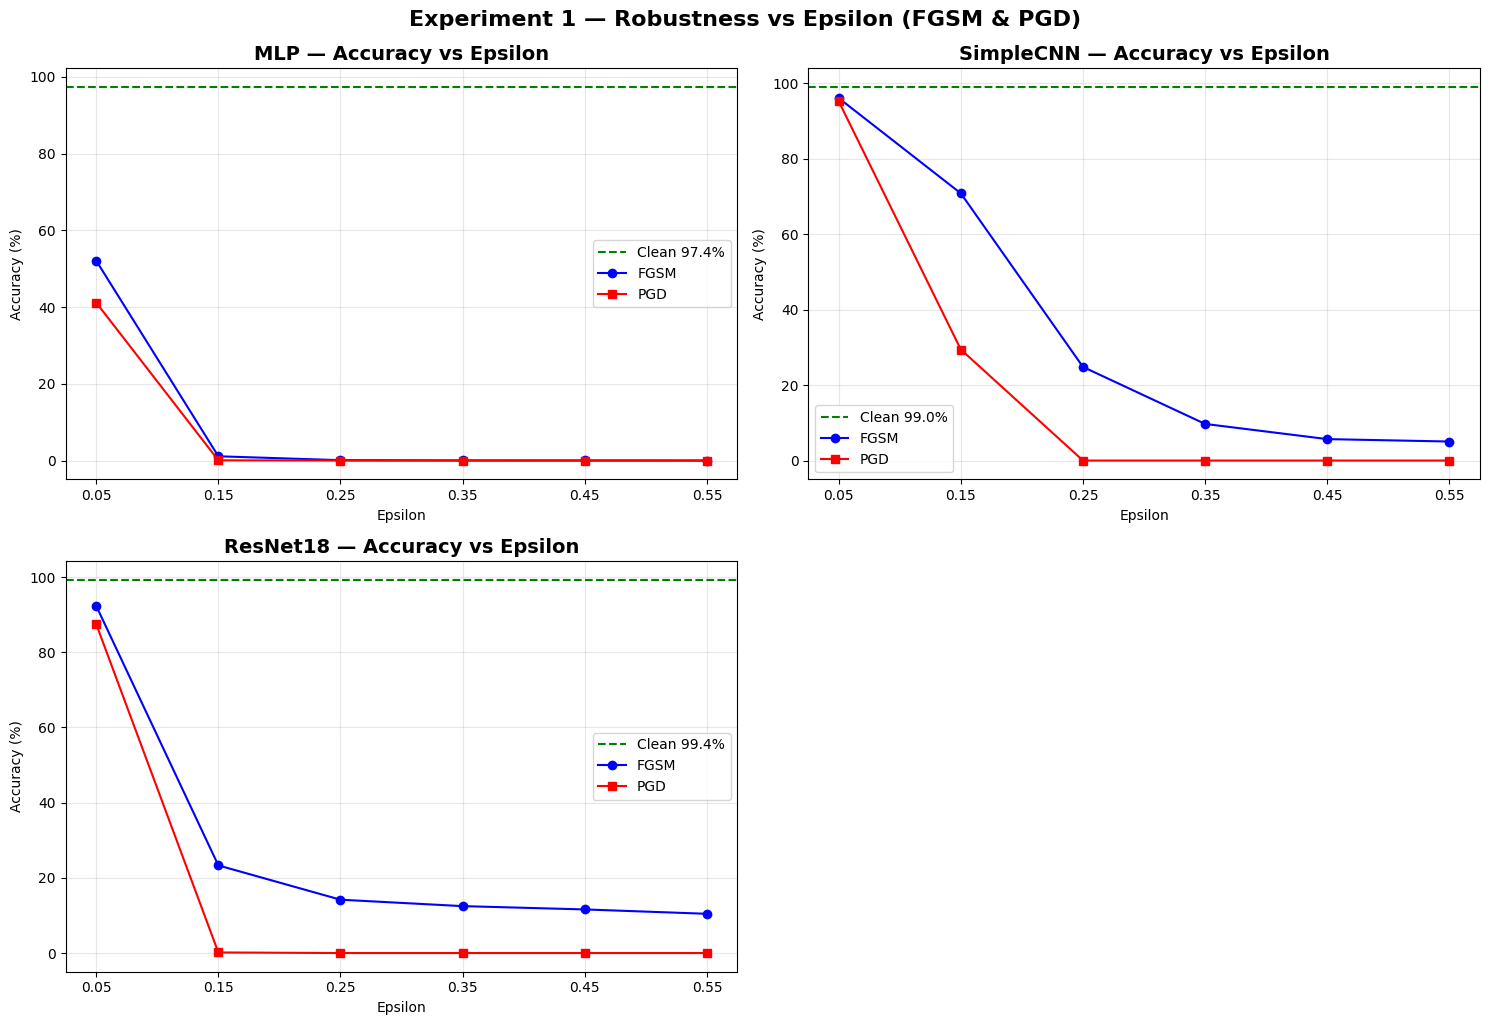


🔬 Running Experiment 1 — Epsilon Sweep (FGSM vs PGD) — FashionMNIST

🚀 Training small models...
Epoch 1/5 — Train: loss=0.5135, acc=81.61% | Val: loss=0.4127, acc=85.25%
Epoch 2/5 — Train: loss=0.3637, acc=86.77% | Val: loss=0.3714, acc=86.48%
Epoch 3/5 — Train: loss=0.3271, acc=87.91% | Val: loss=0.3645, acc=87.10%
Epoch 4/5 — Train: loss=0.3015, acc=88.85% | Val: loss=0.3437, acc=87.53%
Epoch 5/5 — Train: loss=0.2813, acc=89.65% | Val: loss=0.3686, acc=86.66%
   ✔ MLP ready
Epoch 1/5 — Train: loss=0.4609, acc=83.45% | Val: loss=0.3388, acc=87.92%
Epoch 2/5 — Train: loss=0.2950, acc=89.29% | Val: loss=0.3080, acc=88.69%
Epoch 3/5 — Train: loss=0.2431, acc=91.08% | Val: loss=0.2718, acc=90.25%
Epoch 4/5 — Train: loss=0.2121, acc=92.24% | Val: loss=0.2514, acc=90.90%
Epoch 5/5 — Train: loss=0.1844, acc=93.17% | Val: loss=0.2501, acc=91.23%
   ✔ SimpleCNN ready
Epoch 1/5 — Train: loss=0.4033, acc=85.19% | Val: loss=0.2811, acc=89.98%
Epoch 2/5 — Train: loss=0.2661, acc=90.30% | Val: los

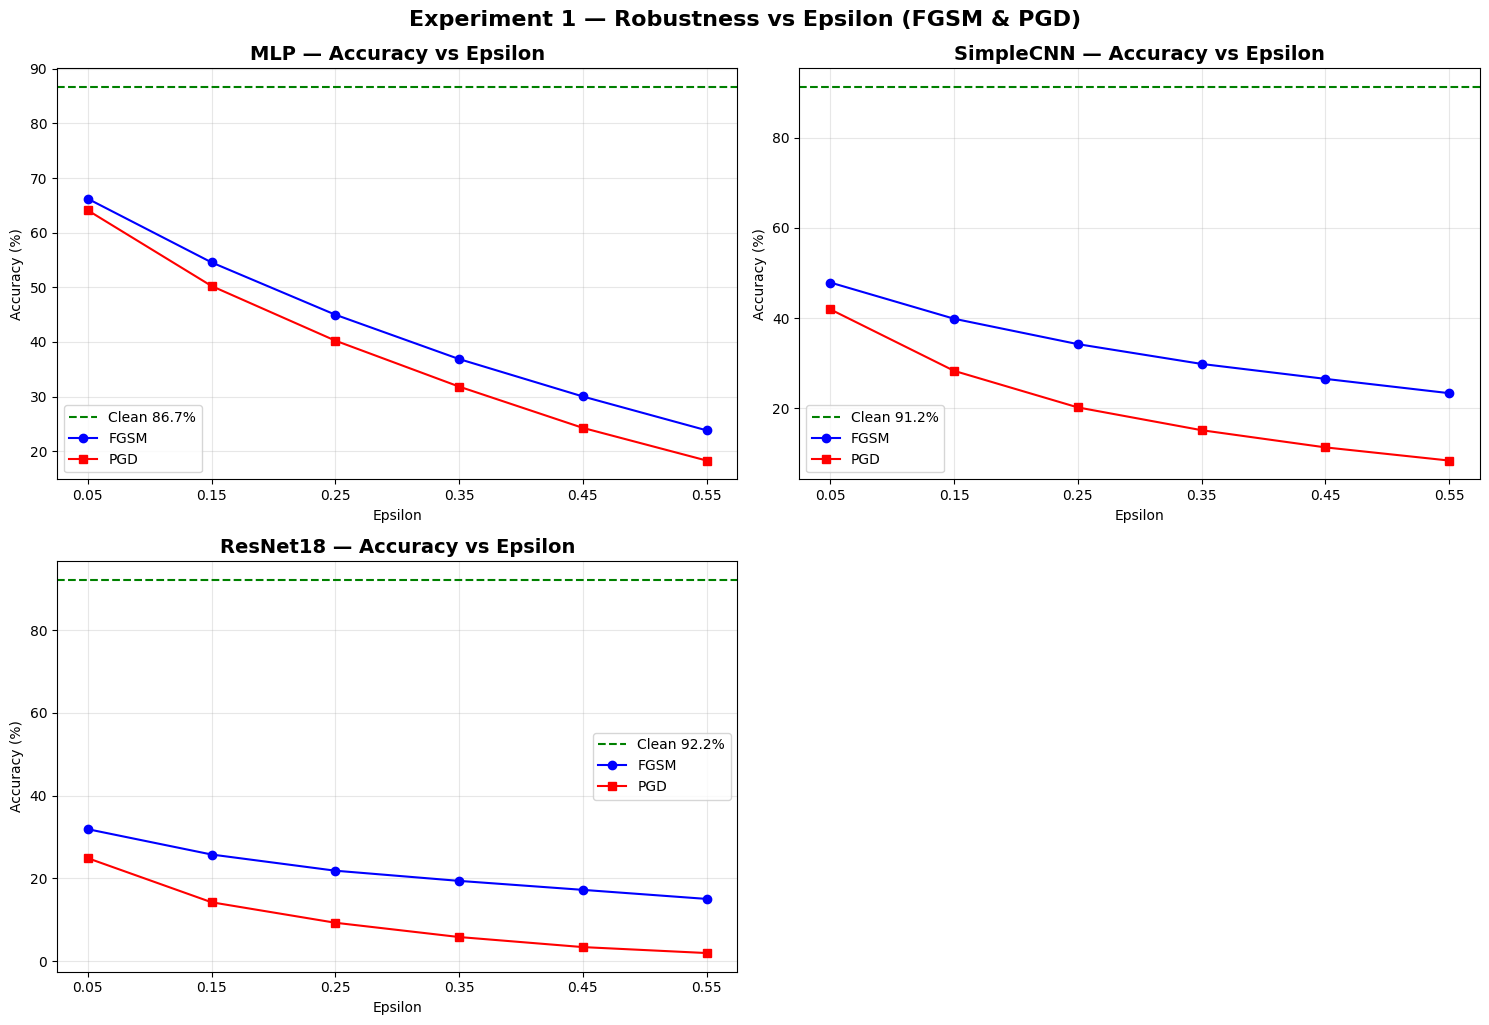


🔬 Running Experiment 1 — Epsilon Sweep (FGSM vs PGD) — CIFAR10

🚀 Training small models...
Epoch 1/5 — Train: loss=1.6685, acc=40.78% | Val: loss=1.5715, acc=44.06%
Epoch 2/5 — Train: loss=1.4726, acc=48.15% | Val: loss=1.4615, acc=48.04%
Epoch 3/5 — Train: loss=1.3774, acc=51.67% | Val: loss=1.4271, acc=49.73%
Epoch 4/5 — Train: loss=1.3031, acc=54.32% | Val: loss=1.4016, acc=50.71%
Epoch 5/5 — Train: loss=1.2464, acc=56.33% | Val: loss=1.3945, acc=51.70%
   ✔ MLP ready
Epoch 1/5 — Train: loss=1.3414, acc=52.30% | Val: loss=1.1004, acc=61.16%
Epoch 2/5 — Train: loss=0.9676, acc=66.11% | Val: loss=0.9157, acc=67.91%
Epoch 3/5 — Train: loss=0.8205, acc=71.07% | Val: loss=0.8957, acc=68.90%
Epoch 4/5 — Train: loss=0.7086, acc=75.42% | Val: loss=0.8468, acc=70.63%
Epoch 5/5 — Train: loss=0.6155, acc=78.57% | Val: loss=0.8226, acc=71.74%
   ✔ SimpleCNN ready
Epoch 1/5 — Train: loss=1.3077, acc=52.34% | Val: loss=1.0606, acc=62.64%
Epoch 2/5 — Train: loss=0.8359, acc=70.51% | Val: loss=0.8

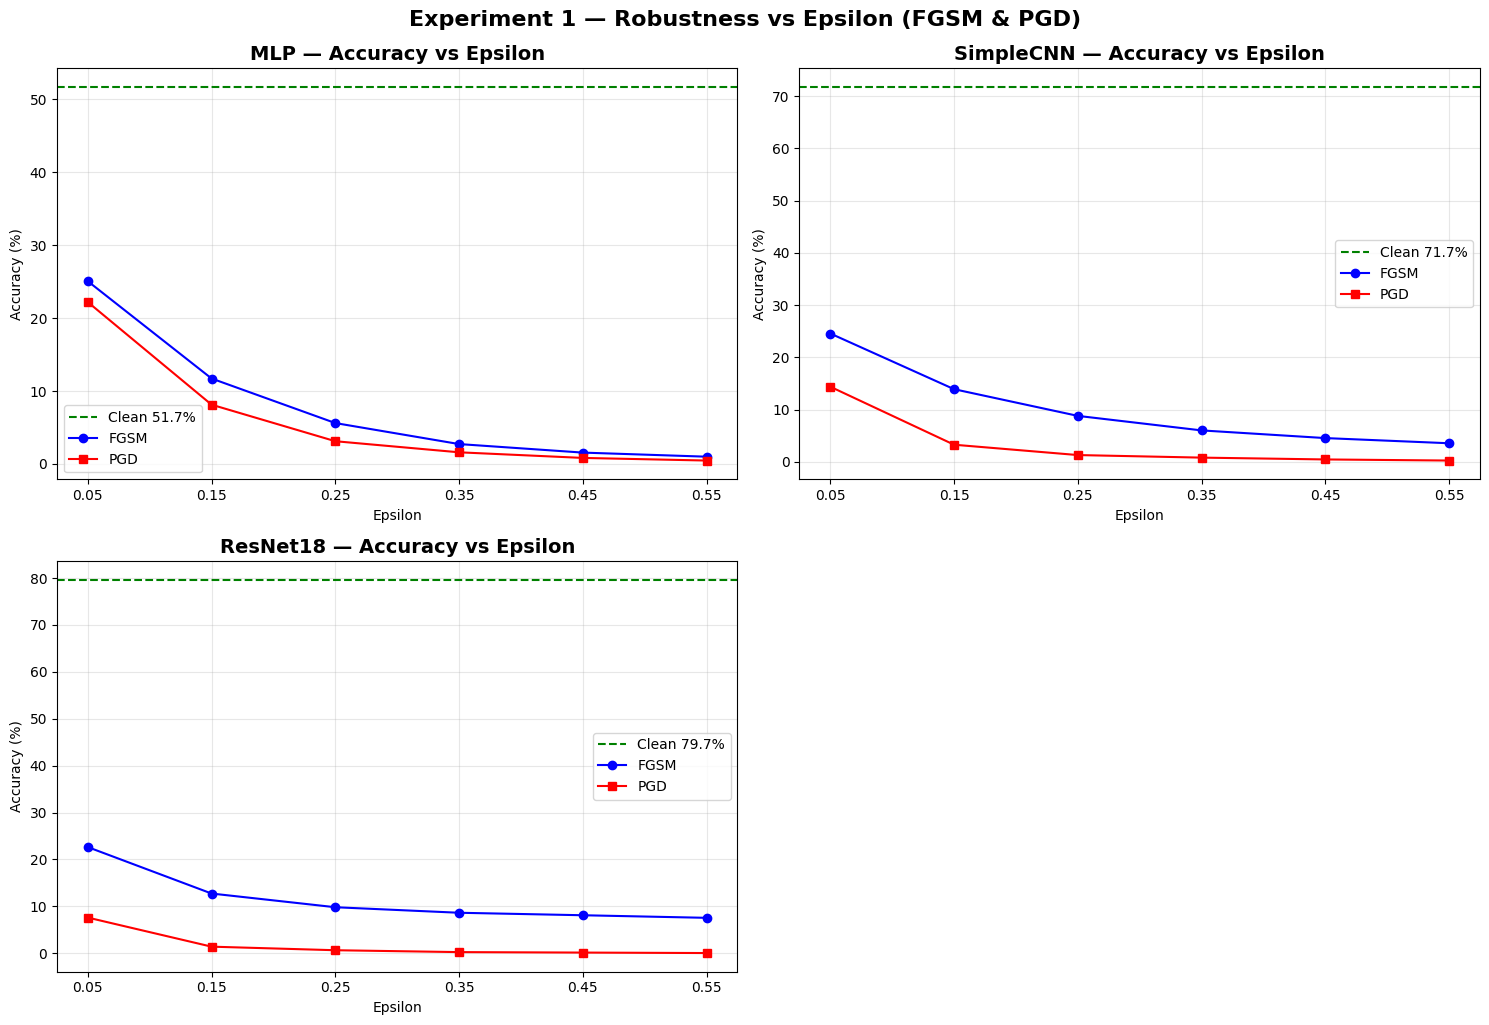

In [ ]:
for ds in DATASETS:
    cfg = DATASETS[ds]
    models = build_models(cfg["input_channels"], cfg["img_size"])
    train_loader = cfg["train_loader"]
    run_experiment_1_for(ds)


🔬 Experiment 2 — PGD Steps Ablation Study — MNIST
Epoch 1/5 — Train: loss=0.2393, acc=92.75% | Val: loss=0.0618, acc=97.98%
Epoch 2/5 — Train: loss=0.0603, acc=98.13% | Val: loss=0.0431, acc=98.55%
Epoch 3/5 — Train: loss=0.0413, acc=98.74% | Val: loss=0.0331, acc=98.89%
Epoch 4/5 — Train: loss=0.0298, acc=99.07% | Val: loss=0.0338, acc=98.94%
Epoch 5/5 — Train: loss=0.0228, acc=99.27% | Val: loss=0.0291, acc=99.08%
⚡ Evaluating PGD at fixed eps=0.25 with different step counts...



PGD Steps = 1: 100%|██████████| 40/40 [00:01<00:00, 32.67it/s]


Steps=1 → Acc=23.85% | ASR=75.27%


PGD Steps = 2: 100%|██████████| 40/40 [00:01<00:00, 22.42it/s]


Steps=2 → Acc=5.52% | ASR=93.62%


PGD Steps = 3: 100%|██████████| 40/40 [00:01<00:00, 24.89it/s]


Steps=3 → Acc=2.51% | ASR=96.61%


PGD Steps = 4: 100%|██████████| 40/40 [00:01<00:00, 27.41it/s]


Steps=4 → Acc=1.66% | ASR=97.47%


PGD Steps = 5: 100%|██████████| 40/40 [00:01<00:00, 24.21it/s]


Steps=5 → Acc=1.32% | ASR=97.80%


PGD Steps = 10: 100%|██████████| 40/40 [00:02<00:00, 14.79it/s]


Steps=10 → Acc=0.73% | ASR=98.40%


PGD Steps = 15: 100%|██████████| 40/40 [00:03<00:00, 10.14it/s]


Steps=15 → Acc=0.71% | ASR=98.44%


PGD Steps = 20: 100%|██████████| 40/40 [00:05<00:00,  7.68it/s]


Steps=20 → Acc=0.52% | ASR=98.60%


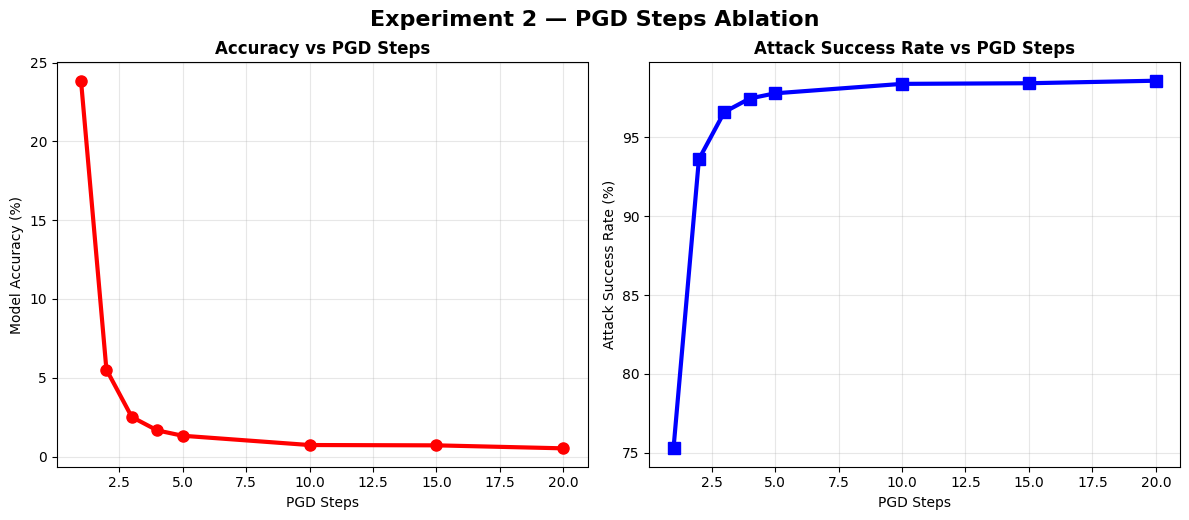


🔬 Experiment 2 — PGD Steps Ablation Study — FashionMNIST
Epoch 1/5 — Train: loss=0.4516, acc=83.70% | Val: loss=0.3522, acc=87.58%
Epoch 2/5 — Train: loss=0.2942, acc=89.28% | Val: loss=0.2907, acc=89.43%
Epoch 3/5 — Train: loss=0.2396, acc=91.11% | Val: loss=0.2528, acc=91.01%
Epoch 4/5 — Train: loss=0.2050, acc=92.45% | Val: loss=0.2543, acc=91.01%
Epoch 5/5 — Train: loss=0.1786, acc=93.47% | Val: loss=0.2360, acc=91.44%
⚡ Evaluating PGD at fixed eps=0.25 with different step counts...



PGD Steps = 1: 100%|██████████| 40/40 [00:02<00:00, 17.75it/s]


Steps=1 → Acc=30.00% | ASR=66.03%


PGD Steps = 2: 100%|██████████| 40/40 [00:02<00:00, 19.59it/s]


Steps=2 → Acc=26.82% | ASR=69.13%


PGD Steps = 3: 100%|██████████| 40/40 [00:02<00:00, 19.25it/s]


Steps=3 → Acc=25.76% | ASR=70.31%


PGD Steps = 4: 100%|██████████| 40/40 [00:02<00:00, 18.38it/s]


Steps=4 → Acc=25.18% | ASR=70.91%


PGD Steps = 5: 100%|██████████| 40/40 [00:02<00:00, 16.28it/s]


Steps=5 → Acc=24.88% | ASR=71.28%


PGD Steps = 10: 100%|██████████| 40/40 [00:03<00:00, 11.64it/s]


Steps=10 → Acc=24.16% | ASR=72.06%


PGD Steps = 15: 100%|██████████| 40/40 [00:03<00:00, 10.10it/s]


Steps=15 → Acc=24.26% | ASR=72.02%


PGD Steps = 20: 100%|██████████| 40/40 [00:05<00:00,  7.67it/s]


Steps=20 → Acc=24.14% | ASR=72.06%


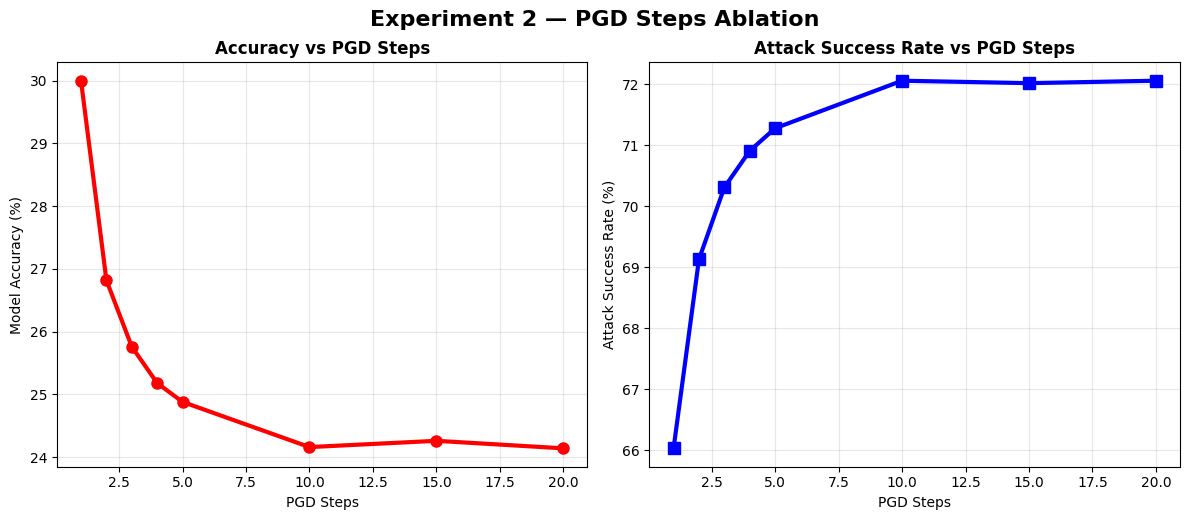


🔬 Experiment 2 — PGD Steps Ablation Study — CIFAR10
Epoch 1/5 — Train: loss=1.3757, acc=50.60% | Val: loss=1.1012, acc=61.05%
Epoch 2/5 — Train: loss=0.9993, acc=64.85% | Val: loss=0.9640, acc=65.60%
Epoch 3/5 — Train: loss=0.8388, acc=70.63% | Val: loss=0.8712, acc=69.34%
Epoch 4/5 — Train: loss=0.7265, acc=74.60% | Val: loss=0.8585, acc=70.65%
Epoch 5/5 — Train: loss=0.6301, acc=77.95% | Val: loss=0.8325, acc=71.72%
⚡ Evaluating PGD at fixed eps=0.25 with different step counts...



PGD Steps = 1: 100%|██████████| 40/40 [00:02<00:00, 18.29it/s]


Steps=1 → Acc=3.96% | ASR=87.18%


PGD Steps = 2: 100%|██████████| 40/40 [00:02<00:00, 16.15it/s]


Steps=2 → Acc=3.05% | ASR=88.05%


PGD Steps = 3: 100%|██████████| 40/40 [00:03<00:00, 12.97it/s]


Steps=3 → Acc=2.72% | ASR=88.34%


PGD Steps = 4: 100%|██████████| 40/40 [00:02<00:00, 15.35it/s]


Steps=4 → Acc=2.56% | ASR=88.62%


PGD Steps = 5: 100%|██████████| 40/40 [00:02<00:00, 15.52it/s]


Steps=5 → Acc=2.45% | ASR=88.59%


PGD Steps = 10: 100%|██████████| 40/40 [00:03<00:00, 12.07it/s]


Steps=10 → Acc=2.20% | ASR=88.96%


PGD Steps = 15: 100%|██████████| 40/40 [00:04<00:00,  8.35it/s]


Steps=15 → Acc=2.16% | ASR=88.90%


PGD Steps = 20: 100%|██████████| 40/40 [00:06<00:00,  6.57it/s]


Steps=20 → Acc=2.14% | ASR=88.97%


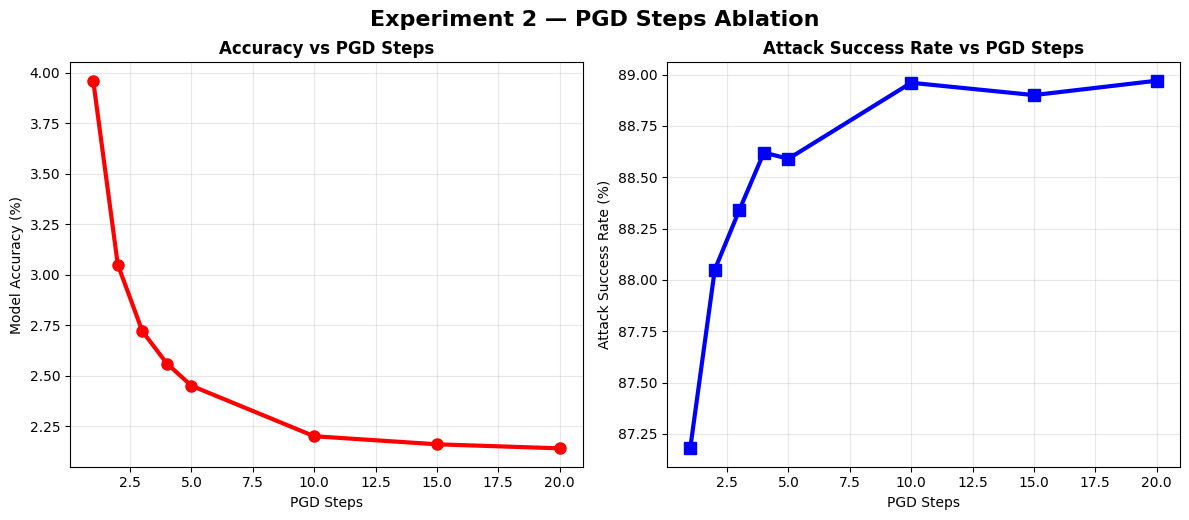

In [ ]:
for ds in DATASETS:
    run_experiment_2_for(ds)


🔬 Experiment 3 — Targeted vs Untargeted Attacks (MNIST)
Epoch 1/5 — Train: loss=0.3228, acc=89.67% | Val: loss=0.0598, acc=98.23%
Epoch 2/5 — Train: loss=0.0785, acc=97.65% | Val: loss=0.0311, acc=98.96%
Epoch 3/5 — Train: loss=0.0553, acc=98.37% | Val: loss=0.0299, acc=98.98%
Epoch 4/5 — Train: loss=0.0439, acc=98.71% | Val: loss=0.0211, acc=99.26%
Epoch 5/5 — Train: loss=0.0357, acc=98.90% | Val: loss=0.0203, acc=99.36%
🎯 Targeted attack class = 9

ε=0.0500 evaluating...


Eps=0.0500: 100%|██████████| 40/40 [00:25<00:00,  1.58it/s]


FGSM  → untargeted=3.0% | targeted=10.5%
PGD   → untargeted=3.1% | targeted=10.5%

ε=0.1500 evaluating...


Eps=0.1500: 100%|██████████| 40/40 [00:25<00:00,  1.57it/s]


FGSM  → untargeted=26.5% | targeted=16.0%
PGD   → untargeted=46.7% | targeted=24.8%

ε=0.2500 evaluating...


Eps=0.2500: 100%|██████████| 40/40 [00:25<00:00,  1.55it/s]


FGSM  → untargeted=73.3% | targeted=32.9%
PGD   → untargeted=99.3% | targeted=88.8%

ε=0.3500 evaluating...


Eps=0.3500: 100%|██████████| 40/40 [00:25<00:00,  1.54it/s]


FGSM  → untargeted=91.3% | targeted=30.2%
PGD   → untargeted=100.0% | targeted=100.0%

ε=0.4500 evaluating...


Eps=0.4500: 100%|██████████| 40/40 [00:26<00:00,  1.53it/s]


FGSM  → untargeted=95.4% | targeted=17.8%
PGD   → untargeted=100.0% | targeted=100.0%

ε=0.5500 evaluating...


Eps=0.5500: 100%|██████████| 40/40 [00:26<00:00,  1.52it/s]


FGSM  → untargeted=96.0% | targeted=8.8%
PGD   → untargeted=100.0% | targeted=100.0%


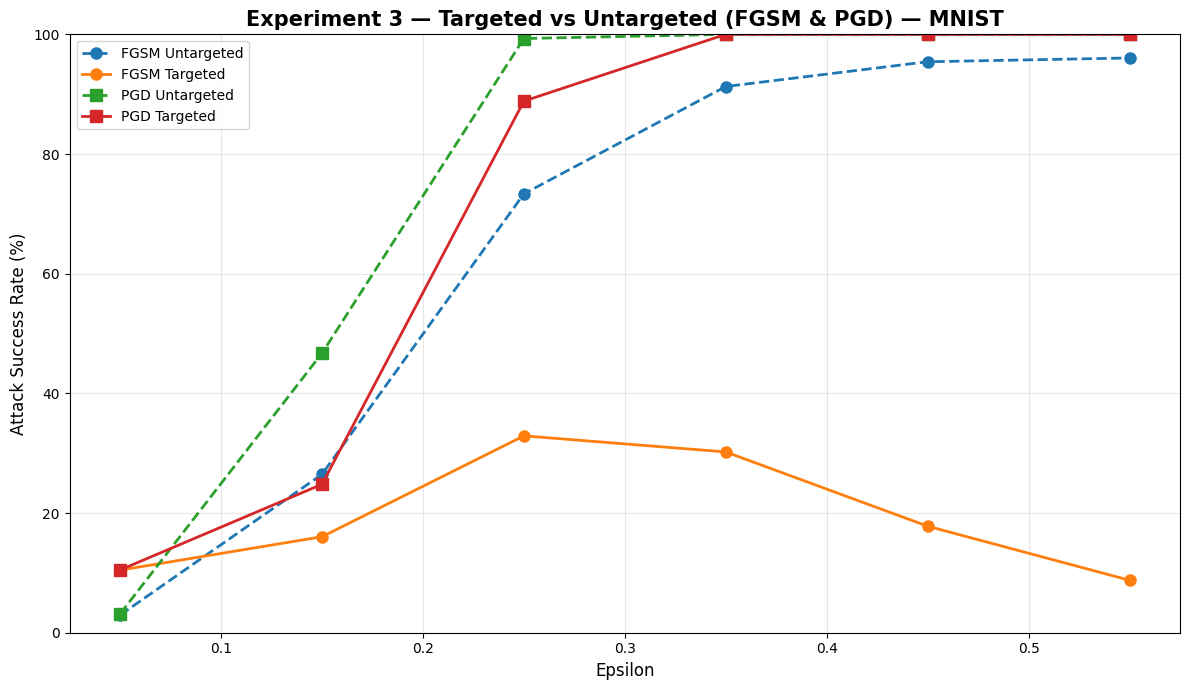


🔬 Experiment 3 — Targeted vs Untargeted Attacks (FashionMNIST)
Epoch 1/5 — Train: loss=0.2914, acc=90.66% | Val: loss=0.0644, acc=97.94%
Epoch 2/5 — Train: loss=0.0806, acc=97.66% | Val: loss=0.0363, acc=98.85%
Epoch 3/5 — Train: loss=0.0553, acc=98.39% | Val: loss=0.0307, acc=98.91%
Epoch 4/5 — Train: loss=0.0429, acc=98.70% | Val: loss=0.0279, acc=99.07%
Epoch 5/5 — Train: loss=0.0362, acc=98.91% | Val: loss=0.0251, acc=99.16%
🎯 Targeted attack class = 9

ε=0.0500 evaluating...


Eps=0.0500: 100%|██████████| 79/79 [00:28<00:00,  2.78it/s]


FGSM  → untargeted=3.6% | targeted=10.5%
PGD   → untargeted=3.7% | targeted=10.5%

ε=0.1500 evaluating...


Eps=0.1500: 100%|██████████| 79/79 [00:28<00:00,  2.76it/s]


FGSM  → untargeted=32.9% | targeted=17.0%
PGD   → untargeted=56.2% | targeted=27.3%

ε=0.2500 evaluating...


Eps=0.2500: 100%|██████████| 79/79 [00:28<00:00,  2.75it/s]


FGSM  → untargeted=78.3% | targeted=35.2%
PGD   → untargeted=99.8% | targeted=94.5%

ε=0.3500 evaluating...


Eps=0.3500: 100%|██████████| 79/79 [00:28<00:00,  2.74it/s]


FGSM  → untargeted=92.8% | targeted=33.5%
PGD   → untargeted=100.0% | targeted=100.0%

ε=0.4500 evaluating...


Eps=0.4500: 100%|██████████| 79/79 [00:28<00:00,  2.73it/s]


FGSM  → untargeted=96.8% | targeted=21.4%
PGD   → untargeted=100.0% | targeted=100.0%

ε=0.5500 evaluating...


Eps=0.5500: 100%|██████████| 79/79 [00:29<00:00,  2.72it/s]


FGSM  → untargeted=97.7% | targeted=10.3%
PGD   → untargeted=100.0% | targeted=100.0%


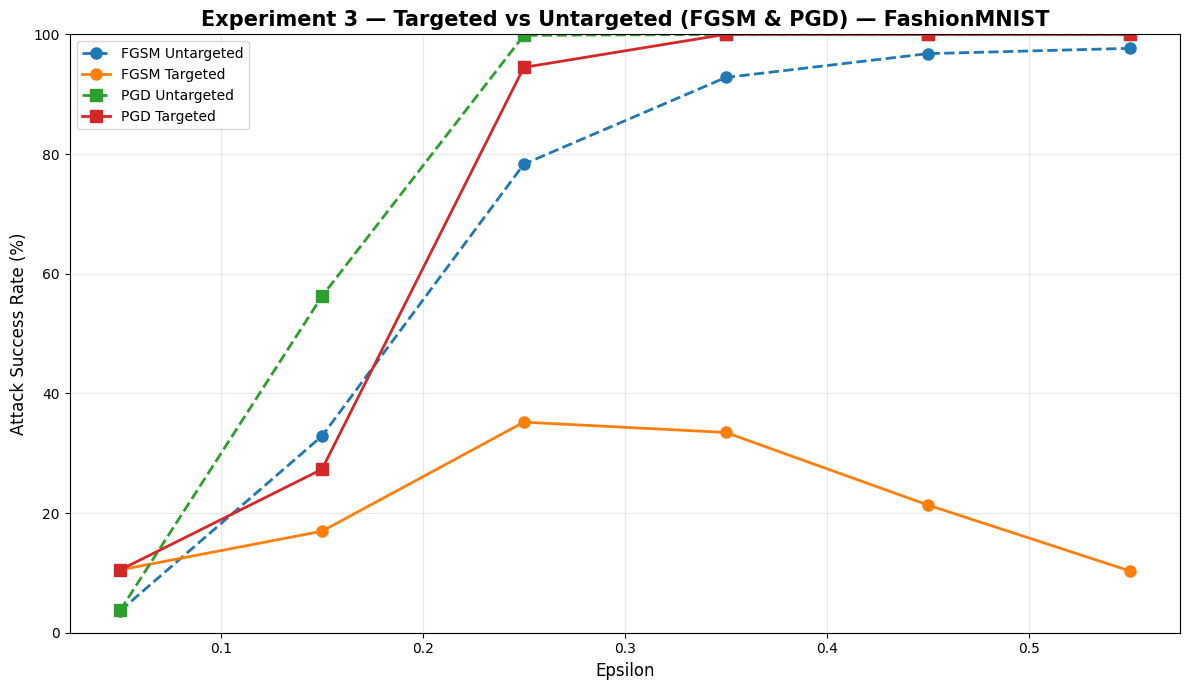


🔬 Experiment 3 — Targeted vs Untargeted Attacks (CIFAR10)


RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[128, 3, 32, 32] to have 1 channels, but got 3 channels instead

In [ ]:
for ds in DATASETS:
    run_experiment_3_for(ds)


🔬 Experiment 4 — Transferability / Black-Box Attacks — MNIST

🚀 Training all models...
Training MLP ...
Epoch 1/5 — Train: loss=0.4215, acc=88.61% | Val: loss=0.2165, acc=93.55%
Epoch 2/5 — Train: loss=0.1796, acc=94.75% | Val: loss=0.1480, acc=95.63%
Epoch 3/5 — Train: loss=0.1275, acc=96.20% | Val: loss=0.1142, acc=96.49%
Epoch 4/5 — Train: loss=0.0975, acc=97.05% | Val: loss=0.0990, acc=97.04%
Epoch 5/5 — Train: loss=0.0761, acc=97.64% | Val: loss=0.0932, acc=97.20%
Training SimpleCNN ...
Epoch 1/5 — Train: loss=0.2376, acc=92.84% | Val: loss=0.0678, acc=97.77%
Epoch 2/5 — Train: loss=0.0621, acc=98.11% | Val: loss=0.0381, acc=98.78%
Epoch 3/5 — Train: loss=0.0422, acc=98.71% | Val: loss=0.0363, acc=98.66%
Epoch 4/5 — Train: loss=0.0296, acc=99.06% | Val: loss=0.0318, acc=98.88%
Epoch 5/5 — Train: loss=0.0230, acc=99.22% | Val: loss=0.0305, acc=99.07%
Training ResNet18 ...
Epoch 1/5 — Train: loss=0.1072, acc=96.73% | Val: loss=0.0631, acc=98.15%
Epoch 2/5 — Train: loss=0.0529, acc=

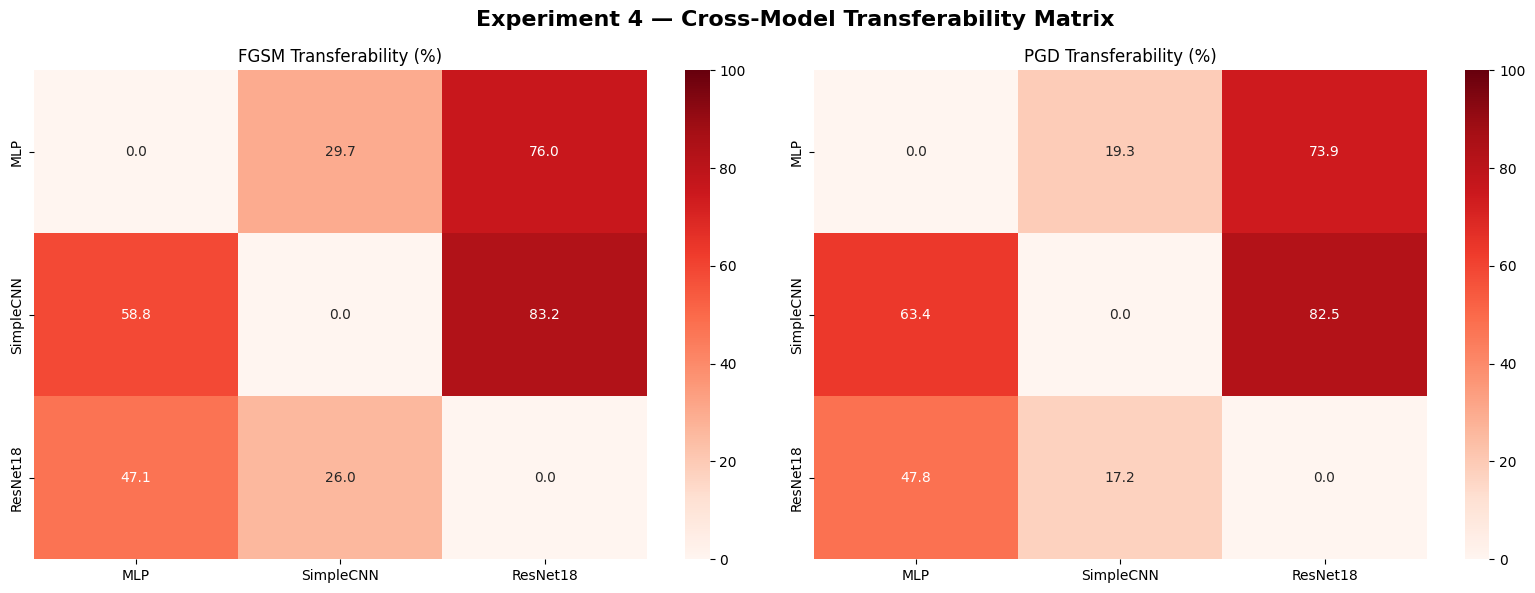


🔬 Experiment 4 — Transferability / Black-Box Attacks — FashionMNIST

🚀 Training all models...
Training MLP ...
Epoch 1/5 — Train: loss=0.5116, acc=81.54% | Val: loss=0.4372, acc=83.88%
Epoch 2/5 — Train: loss=0.3682, acc=86.50% | Val: loss=0.3949, acc=86.05%
Epoch 3/5 — Train: loss=0.3282, acc=87.92% | Val: loss=0.3865, acc=85.46%
Epoch 4/5 — Train: loss=0.3032, acc=88.69% | Val: loss=0.3577, acc=87.04%
Epoch 5/5 — Train: loss=0.2820, acc=89.56% | Val: loss=0.3574, acc=87.10%
Training SimpleCNN ...
Epoch 1/5 — Train: loss=0.4569, acc=83.69% | Val: loss=0.3269, acc=87.86%
Epoch 2/5 — Train: loss=0.2942, acc=89.41% | Val: loss=0.2896, acc=89.38%
Epoch 3/5 — Train: loss=0.2408, acc=91.20% | Val: loss=0.2627, acc=90.53%
Epoch 4/5 — Train: loss=0.2051, acc=92.50% | Val: loss=0.2442, acc=90.96%
Epoch 5/5 — Train: loss=0.1776, acc=93.47% | Val: loss=0.2363, acc=91.40%
Training ResNet18 ...
Epoch 1/5 — Train: loss=0.3907, acc=85.66% | Val: loss=0.3410, acc=87.39%
Epoch 2/5 — Train: loss=0.265

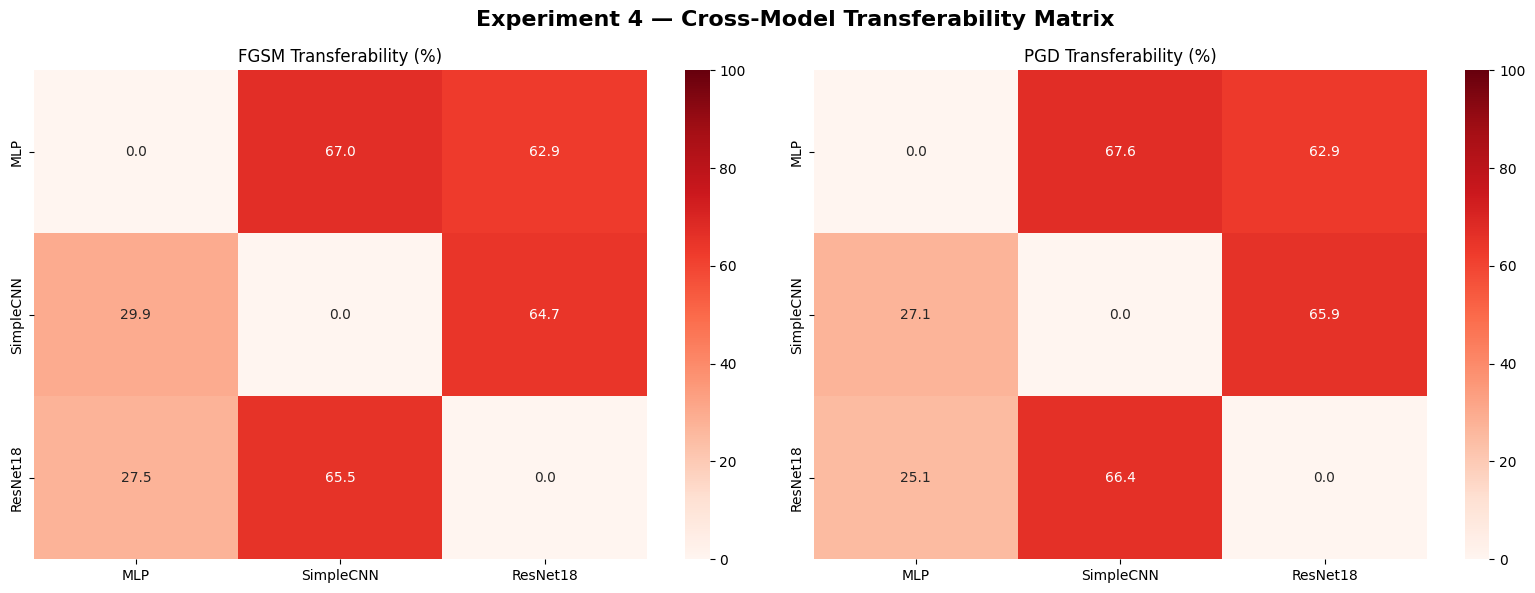


🔬 Experiment 4 — Transferability / Black-Box Attacks — CIFAR10

🚀 Training all models...
Training MLP ...
Epoch 1/5 — Train: loss=1.6665, acc=41.17% | Val: loss=1.5311, acc=46.07%
Epoch 2/5 — Train: loss=1.4672, acc=48.32% | Val: loss=1.4568, acc=49.34%
Epoch 3/5 — Train: loss=1.3735, acc=51.84% | Val: loss=1.4219, acc=49.64%
Epoch 4/5 — Train: loss=1.3025, acc=54.39% | Val: loss=1.4163, acc=50.02%
Epoch 5/5 — Train: loss=1.2458, acc=56.20% | Val: loss=1.4078, acc=50.73%
Training SimpleCNN ...
Epoch 1/5 — Train: loss=1.3418, acc=52.43% | Val: loss=1.0667, acc=62.43%
Epoch 2/5 — Train: loss=0.9851, acc=65.74% | Val: loss=0.9464, acc=66.66%
Epoch 3/5 — Train: loss=0.8404, acc=70.62% | Val: loss=0.8816, acc=69.09%
Epoch 4/5 — Train: loss=0.7295, acc=74.56% | Val: loss=0.8579, acc=70.33%
Epoch 5/5 — Train: loss=0.6359, acc=77.75% | Val: loss=0.8179, acc=72.19%
Training ResNet18 ...
Epoch 1/5 — Train: loss=1.3138, acc=52.19% | Val: loss=1.1528, acc=57.31%
Epoch 2/5 — Train: loss=0.8464, ac

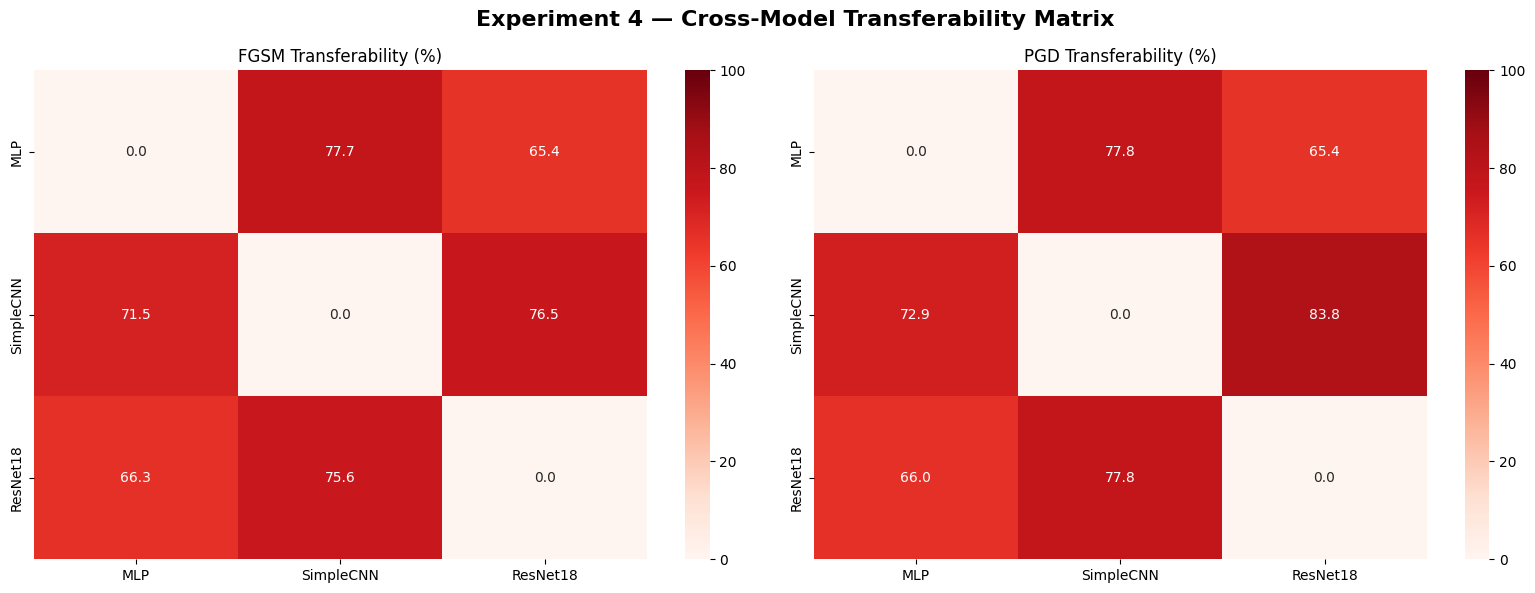

In [ ]:
for ds in DATASETS:
    run_experiment_4_for(ds)